In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [40]:
import gzip
import shutil
import os

In [11]:
%matplotlib inline

In [35]:
class DataGenerator(object):
    amp = [10.0, 1.0, 0.5, 0.1]
    frq = [1.0 * np.pi, 0.1 * np.pi, 3.0 * np.pi, 10.0 * np.pi]
    DTYPE = np.float32
    
    def __init__(self, time_step=0.01):
        self.t = 0
        self.time_step = time_step
        assert len(DataGenerator.amp) == len(DataGenerator.frq)
        
    def _gen_point(self):
        raw_vs = []
        for i in range(len(DataGenerator.amp)):
            raw_vs.append(
                DataGenerator.amp[i] * np.cos(DataGenerator.frq[i] * self.t)
            )
        return np.asarray(raw_vs, dtype=DataGenerator.DTYPE)
    
    def step(self):
        data = self._gen_point()
        self.t = self.t + self.time_step
        return data

In [36]:
class NoiseModel(object):
    default_noise_scale = [0.05, 0.04, 0.02, 0.01]
    DTYPE = np.float32
    
    def __init__(self, drop_probability=0.0, noise_array=None):
        self.noise = noise_array or NoiseModel.default_noise_scale
        assert len(self.noise) == 4
    
    def gen_noise(self, data):
        assert len(data) == 4
        noise_values = []
        for i, d in enumerate(data):
            noise_values.append(
                self.noise[i] * data[i] * np.random.randn()
            )
        return np.asarray(noise_values, dtype=NoiseModel.DTYPE)

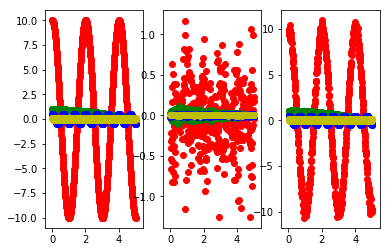

In [37]:
dgen = DataGenerator()
nosgen = NoiseModel()
d1 = []
d2 = []
d3 = []
d4 = []
n1 = []
n2 = []
n3 = []
n4 = []
m1 = []
m2 = []
m3 = []
m4 = []
ts = []
for i in range(500):
    data = dgen.step()
    noise = nosgen.gen_noise(data)
    measured = data + noise
    ts.append(dgen.t)
    for i, a in enumerate([d1, d2, d3, d4]):
        a.append(data[i])
    for i, n in enumerate([n1, n2, n3, n4]):
        n.append(noise[i])
    for i, m in enumerate([m1, m2, m3, m4]):
        m.append(measured[i])

fig = plt.Figure()
gs = plt.GridSpec(1, 3)
ax1 = plt.subplot(gs[0])
ax1.scatter(ts, d1, c='r')
ax1.scatter(ts, d2, c='g')
ax1.scatter(ts, d3, c='b')
ax1.scatter(ts, d4, c='y')
ax2 = plt.subplot(gs[1])
ax2.scatter(ts, n1, c='r')
ax2.scatter(ts, n2, c='g')
ax2.scatter(ts, n3, c='b')
ax2.scatter(ts, n4, c='y')
ax3 = plt.subplot(gs[2])
ax3.scatter(ts, m1, c='r')
ax3.scatter(ts, m2, c='g')
ax3.scatter(ts, m3, c='b')
ax3.scatter(ts, m4, c='y')
plt.show()

In [44]:
class MachineStateTextRecorder(object):
    
    def __init__(self, log_base_name):
        self.log_name = log_base_name + '.csv'
        self.gzfile = self.log_name + '.gz'
        self.cleanup_files()
        
    def cleanup_files(self):
        for f in [self.log_name, self.gzfile]:
            if os.path.isfile(f):
                os.remove(f)
        
    def write_data(self, t, measurements, targets):
        '''measurements are measured sensors, targets are true values'''
        try:
            with open(self.log_name, 'ab+') as f:
                meas_string = ','.join([str(i) for i in measurements])
                targ_string = ','.join([str(i) for i in targets])
                msg = str(t) + ',' + meas_string + ',' + targ_string + '\n'
                f.write(bytes(msg, 'utf8'))
            return True
        except Exception as e:
            raise e
        return False

    def read_data(self):
        '''
        do not call this on large files
        NOTE: we are assuming gzip compression has occurred!
        '''
        with gzip.open(self.log_name + '.gz', 'rb') as f:
            content = f.readlines()
            content = [x.strip() for x in content]
        return content
    
    def close(self):
        with open(self.log_name, 'rb') as f_in:
            with gzip.open(self.gzfile, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        if os.path.isfile(self.gzfile) and (os.stat(self.gzfile).st_size > 0):
            os.remove(self.db_name)
        else:
            raise IOError('Compressed file not produced!')

In [39]:
class SimulationMachine(object):
    
    def __init__(self, data_generator, noise_model, logger=None):
        self.data_generator = data_generator
        self.noise_model = noise_model
        self.setting = 0.0
        self.heat = 0.0
        if logger is None:
            self.live_mode = True
        else:
            self.live_mode = False
            self.logger = logger
        
    def step(self):
        pass
    
    def get_heat(self):
        pass